```
BEGIN ASSIGNMENT
requirements: ../../requirements.txt
overwrite_requirements: true
export_cell:
    pdf: false
solutions_pdf: true
generate:
    show_stdout: true
    seed: 42
files:
    - data.csv
plugins:
    - otter.plugins.builtin.GoogleSheetsGradeOverride:
        credentials_json_path: ../../sheets-api-credentials.json
        sheet_url: https://docs.google.com/spreadsheets/d/1WhPrOz4x18CABYVTHgbThSZgjSL07fwZx4_mOJWs4Ic/edit
```

<table style="width: 100%;">
    <tr style="background-color: transparent;"><td>
        <img src="https://data-88e.github.io/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, Spring 2021<br>
            Dr. Eric Van Dusen<br>
        Shashank Dalmia<br></p></td></tr>
</table>

## Lab 10: Econometrics Part 1

In [237]:
from datascience import  *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
import statsmodels.api as sm
plt.style.use('seaborn-muted')

import warnings
warnings.filterwarnings("ignore")

## Part 0: Introduction

Stock valuations have been a great predictor of future returns. In this lab, we will take a look at how good valuations actually are and the limitations of this analysis. Also, we will learn regression in the process.

This [article](https://www.wsj.com/articles/the-economy-is-recovering-how-to-invest-when-everything-is-expensive-11618063500?mod=business_minor_pos10) in the Wall Street Journal is a great example of what we are going to be doing. (Also very timely as it was published just a few days before this lab was released).

Note: UC Berkeley students have free access to WSJ. But if you can't access the article, here is a [pdf](https://drive.google.com/file/d/1kerB5h5bhTukfR3aYgutT81EIjXLsvHf/view?usp=sharing).

<img src="headline.png">

The headline alludes to an idea that at high and expensive valuations, future returns in stock market will be lower. Lets try to test out the hypothesis.

First, lets load the data and take a look at it. This comes from a combination of [Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC), [FRED](https://fred.stlouisfed.org/graph/?g=qis) and [Nobel laureate Prof Robert Schiller](http://www.econ.yale.edu/~shiller/data.htm).

(Disclamer: This lab does not provide any investment advice.)

In [238]:
data = Table().read_table("data.csv")
data

Date,Shiller P/E,S&P 500 Closing Price,Equity Allocation
1980-04-01,7.84,102.09,0.25536
1980-07-01,8.88,114.24,0.27304
1980-10-01,9.36,125.46,0.2867
1981-01-01,9.26,135.76,0.28395
1981-04-01,9.09,136,0.27491
1981-07-01,8.45,131.21,0.24257
1981-10-01,7.65,116.18,0.25134
1982-01-01,7.39,122.55,0.2269
1982-04-01,7.26,111.96,0.21878
1982-07-01,6.64,109.61,0.23082


The data contains quartely S&P 500 closing price. The [S&P 500](https://en.wikipedia.org/wiki/S%26P_500),  or simply the S&P, is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices.

Schiller P/E is Prof Shillers version of the Price to Earnings (P/E) ratio. You can think of P/E as how much would it cost you now to get the earnings of the company for subsequent years.

For example, a single share of a company costs \\$40. That company produces \\$2 earnings per share in a year. The P/E ratio will be 40/2 = 20. 

Lets plot some data.

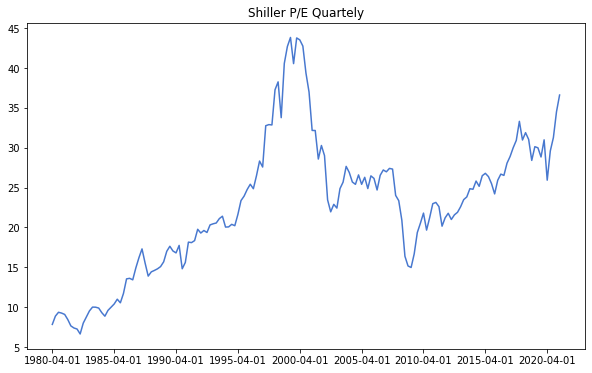

In [239]:
tick_spacing = 20
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.plot(data.column("Date"), data.column("Shiller P/E"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.title("Shiller P/E Quartely")
plt.show();

You can see that the Shiller P/E is at one of its highest levels seen. The only time it excced current levels is the 2004 dot com bubble.

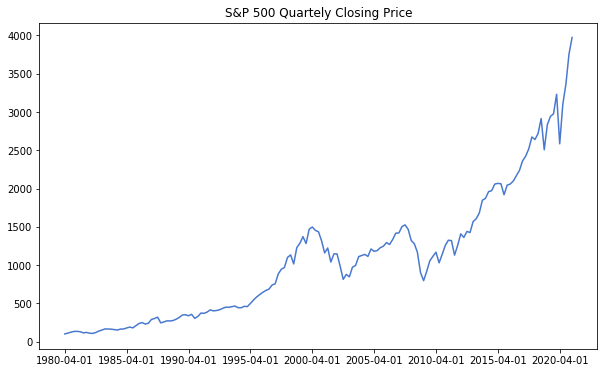

In [240]:
tick_spacing = 20
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.plot(data.column("Date"), data.column("S&P 500 Closing Price"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.title("S&P 500 Quartely Closing Price")
plt.show();

This just shows what we read about so far; the market goes up in the long run. However, we care about actual percentage returns; whether they are high or low or even negative.

For this purpose of predicting returns, we are going to use Shiller P/E as a explantory variable. The idea is to predict the following.

**If I buy the S&P today, given that the P/E is 36.61, what will be my best prediction for the return I get?**

## Part 1: Calculating Returns

First lets calcuate returns. The formula for calulating annualized returns for _n_ years is 

$ (\dfrac{Future Price}{Old Price})^{\frac{1}{n}} -1 $ 

We will chose a 10 year period to calcuate subsequent returns (becuase we want to know what we would get in returns if we invest now and wait for 10 years). For example, S&P 500 on 1980-04-01 is 102.09. Ten years ahead, on 1990-04-01, the S&P 500 index is at 339.94. So the 10 year subsequent returns calcuated on 1980-04-01 are 

$ (\dfrac{339.94}{102.09})^{\frac{1}{10}} -1  = 0.127$ 

That represents a 12.7% annualized return.

**Question 1.1:** Calculate 10 year subsequent annualized return for our data. Naturally, we dont have future prices for recent data, so we cant compute that (i.e. cant compute 10 years returns for 2011-07-01 onwards as 10 years have not passed. Store the values in an array called `returns`.


_Hint:_ For each year, we have 4 values; one for each quarter. Think about what slice of the data you need to get the years you want.

```
BEGIN QUESTION
name: q1_1
points: 2
manual: false
```

In [241]:
# BEGIN SOLUTION NO PROMPT
old = data.where("Date", are.below("2011-07-01")).column("S&P 500 Closing Price")
new = data.where("Date", are.above("1990-01-01")).column("S&P 500 Closing Price")
returns = (new/old)**(0.1) - 1
# END SOLUTION
""" # BEGIN PROMPT
old = ...
new = ...
returns = ...
"""; # END PROMPT
returns

array([ 0.12782549,  0.12100845,  0.09327315,  0.0929572 ,  0.10681416,
        0.10958202,  0.12811754,  0.13029453,  0.13683778,  0.14050157,
        0.13247066,  0.11971853,  0.11435695,  0.10360332,  0.10699464,
        0.10955937,  0.10846559,  0.11235772,  0.10787826,  0.10629964,
        0.10731817,  0.11000144,  0.12368745,  0.11292857,  0.10450582,
        0.10333809,  0.11504896,  0.11829027,  0.10007634,  0.11279159,
        0.11399996,  0.1466019 ,  0.15583754,  0.15281454,  0.1410115 ,
        0.16038632,  0.15870677,  0.15749174,  0.13896835,  0.15314236,
        0.15991928,  0.15049213,  0.16721714,  0.14864617,  0.11951406,
        0.12677431,  0.10376109,  0.10655819,  0.11011077,  0.09263402,
        0.06913822,  0.07280214,  0.06504189,  0.08020413,  0.08056275,
        0.09075408,  0.09711177,  0.09889904,  0.09189813,  0.101896  ,
        0.08956033,  0.08139283,  0.07715132,  0.07319446,  0.072091  ,
        0.06595512,  0.06871158,  0.06711256,  0.06497316,  0.05

In [242]:
## TEST ##
len(returns) == 125

True

In [243]:
## TEST ##
np.isclose(returns[0],  0.12782549199196658, atol = 0.05)

True

In [244]:
## HIDDEN TEST ##
np.isclose(returns[-1], 0.11599402624152755, atol = 0.05)

True

**Question 1.2:** Add the returns column to our data table with the column name `10 Year Returns`. Multiply by returns you have calculated by 100 to get % values (easier to interpret that way). The returns array has fewer values than the rows in our data. Use `np.nan` as the return for dates we don't have values for.


_Hint:_ Use [np.repeat](https://numpy.org/doc/stable/reference/generated/numpy.repeat.html)

```
BEGIN QUESTION
name: q1_2
points: 1
manual: false
```

In [245]:
# BEGIN SOLUTION NO PROMPT
modified_returns = np.append(returns, np.repeat(np.nan, 40))*100
data = data.with_columns("10 Year Returns", modified_returns)
# END SOLUTION
""" # BEGIN PROMPT
modified_returns = ...
data = data.with_columns("10 Year Returns", modified_returns)
"""; # END PROMPT
data

Date,Shiller P/E,S&P 500 Closing Price,Equity Allocation,10 Year Returns
1980-04-01,7.84,102.09,0.25536,12.7825
1980-07-01,8.88,114.24,0.27304,12.1008
1980-10-01,9.36,125.46,0.2867,9.32731
1981-01-01,9.26,135.76,0.28395,9.29572
1981-04-01,9.09,136,0.27491,10.6814
1981-07-01,8.45,131.21,0.24257,10.9582
1981-10-01,7.65,116.18,0.25134,12.8118
1982-01-01,7.39,122.55,0.2269,13.0295
1982-04-01,7.26,111.96,0.21878,13.6838
1982-07-01,6.64,109.61,0.23082,14.0502


In [246]:
## TEST ##
data.num_columns == 5

True

In [247]:
## TEST ##
"10 Year Returns" in data.labels

True

In [248]:
## HIDDEN TEST ##
np.count_nonzero(~np.isnan(data.column("10 Year Returns"))) == 125

True

In [249]:
## HIDDEN TEST ##
sum(np.isnan(data.column("10 Year Returns")[-40:])) == 40

True

## Part 2: The Setup

Lets plot the data.

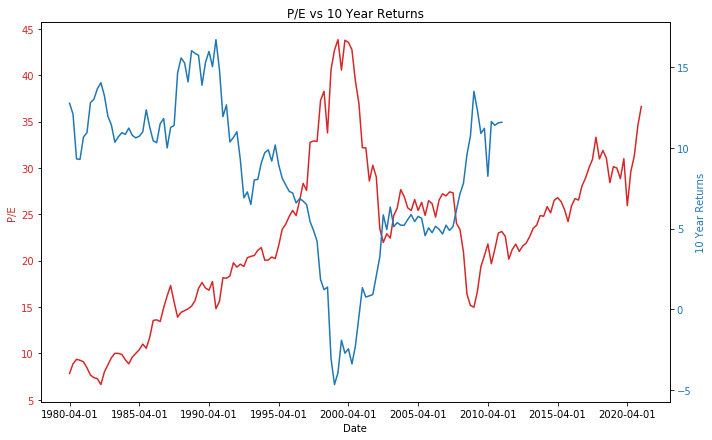

In [250]:
fig, ax1 = plt.subplots(1,1, figsize = (10,6))
tick_spacing = 20

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('P/E', color=color)
ax1.plot(data.column("Date"), data.column("Shiller P/E"), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('10 Year Returns', color=color)  
ax2.plot(data.column("Date"), data.column("10 Year Returns"), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

fig.tight_layout()  

plt.title("P/E vs 10 Year Returns")
plt.show();

As we expect, we can see an inverse relationship between our valuaion metric P/E and returns. 

In 2004, at the peak of the dot com bubble, when valuations were high, 10 year subsequent returns were low (actually negative). 

In 2009, after stocks crashed follwing the recession, stock valuations became very cheap. You can see that those who bought in at low valuations must have made high positive returns. 

Just to show you how well valuations track returns (inversly), I will **flip the P/E y axis**, i.e., smaller values of P/E on top of the axis.

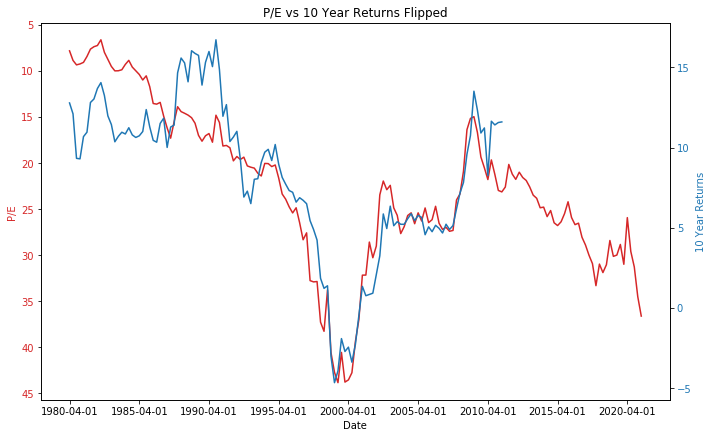

In [251]:
fig, ax1 = plt.subplots(1,1, figsize = (10,6))
tick_spacing = 20

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('P/E', color=color)
ax1.plot(data.column("Date"), data.column("Shiller P/E"), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.invert_yaxis()

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('10 Year Returns', color=color) 
ax2.plot(data.column("Date"), data.column("10 Year Returns"), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

fig.tight_layout()  

plt.title("P/E vs 10 Year Returns Flipped")
plt.show()

Look at how well it tracks. This shows that valuation is a prime candidate to predict returns. Lets do some regression.

## Part 3: Single Variable Regression

In the plot above, we plotted both P/E and future returns against time. For our regression, we will be using P/E to predict the returns. So P/E is our _x_ variable (independent or explanatory variable). Returns are our _y_ variable (or outcome variable).

Lets understand the relationship between the x and y data columns. In the following plot, each dot represents an obervation in time, recording the P/E ratio and the 10 year subsequent returns on that day.

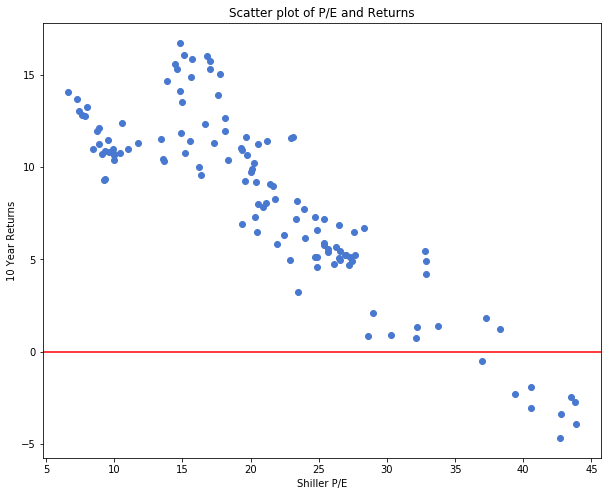

In [252]:
plt.figure(figsize = (10,8))
plt.scatter(data.column("Shiller P/E"), data.column("10 Year Returns"))
plt.xlabel("Shiller P/E")
plt.ylabel("10 Year Returns")
plt.title("Scatter plot of P/E and Returns")
plt.axhline(y=0, color='r', linestyle='-');

This scatterplot provides an even better indication of the strong inverse relationship. In fact, WSJ included a similar image in their article.

<img src="scatterplot.png">

Note that some of the differences in our plot versus the WSJ are becuase they used more data and the scales are different.

**Question 2.1:** Use P/E as an independent variable to predict 10 year returns. Save the regression model to the variable `result`.

Since we have missing returns in the recent 10 years, we will use the `missing = 'drop'` arguement in `sm.OLS()` function.

```
BEGIN QUESTION
name: q2_1
points: 2
manual: false
```

In [253]:
# BEGIN SOLUTION NO PROMPT
x = data.select("Shiller P/E").to_df()                    # Separate features (independent variables) 
y = data.select("10 Year Returns").to_df()                # Separate target (outcome variable)
model = sm.OLS(y, sm.add_constant(x), missing = 'drop')   # Initialize the OLS regression model
result = model.fit()                                      # Fit the regression model and save it to a variable
# END SOLUTION
""" # BEGIN PROMPT
x = data.select(...).to_df()
y = data.select(...).to_df()
model = sm.OLS(..., sm.add_constant(...), missing = 'drop')
result = model.fit()
"""; # END PROMPT
result.summary()                                          # Display a summary of results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        10 Year Returns   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     403.8
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           1.15e-40
Time:                        00:27:05   Log-Likelihood:                -283.92
No. Observations:                 125   AIC:                             571.8
Df Residuals:                     123   BIC:                             577.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          18.0986      0.535     33.807      0.000      17.039      19.158
Shiller P/E    -0.4661      0.023    -20.094      0.000      -0.512      -0.420
==============================================================================
Omnibus:                        7.410   Durbin-Watson:                   0.178
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.779
Skew:                           0.603   Prob(JB):                       0.0205
Kurtosis:                       2.804   Cond. No.                         58.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [254]:
## TEST ##
len(result.params) == 2

True

In [255]:
## TEST ##
sum(np.equal(result.params.index.values, ['const', 'Shiller P/E'])) == 2

True

In [256]:
## HIDDEN TEST ##
np.isclose(result.params[0], 18.09859131490896, atol = 0.05)

True

In [257]:
## HIDDEN TEST ##
np.isclose(result.params[1], -0.4661351634225749, atol = 0.05)

True

**Question 2.2:** What is the sign on $\hat{\beta}$? Does it make sense?

```
BEGIN QUESTION
name: q2_2
manual: true
```

<div class="alert alert-danger">

<strong>SOLUTION:</strong> The sign of $\hat{\beta}$ is negative. It makes sense cause higher the P/E, lower the returns.

</div>




**Question 2.3:** Use the estimates for $\hat{\alpha}$ and $\hat{\beta}$ to predict the returns for 2021-01-01. Store it in a variable called `prediction_today`.

_Hint:_ $\hat{y} = \hat{\alpha} + \hat{\beta}* x$

```
BEGIN QUESTION
name: q2_3
points: 1
manual: false
```

In [258]:
# BEGIN SOLUTION NO PROMPT
prediction_today = result.params[0] + result.params[1]*34.51
# END SOLUTION
""" # BEGIN PROMPT
prediction_today  = ...
"""; # END PROMPT
prediction_today

2.0122668251959013

In [259]:
## TEST ##
prediction_today <= 10

True

In [260]:
## HIDDEN TEST ##
np.isclose(prediction_today, 2.0122668251959013, atol = 0.05)

True

Before we move on, its important to understand the interpretation of $\hat{\beta}$ and by extension regression here. In this lab, we are using regression as a tool for prediction. We are not making any causal inference.

Causal inference is focused on knowing what happens to 𝑌 when you change 𝑋; saying 𝑋 causes 𝑌. Prediction is focused on knowing the next 𝑌 given 𝑋. 

Regression is used for both. It is important to know which purpose you are using it for.

Thus, the interpretation of $\hat{\beta}$ here is as follows. **A 1 unit increase in P/E ratio is associated with a -0.4661 change in Returns.**

Let's plot the predicted values for all years.

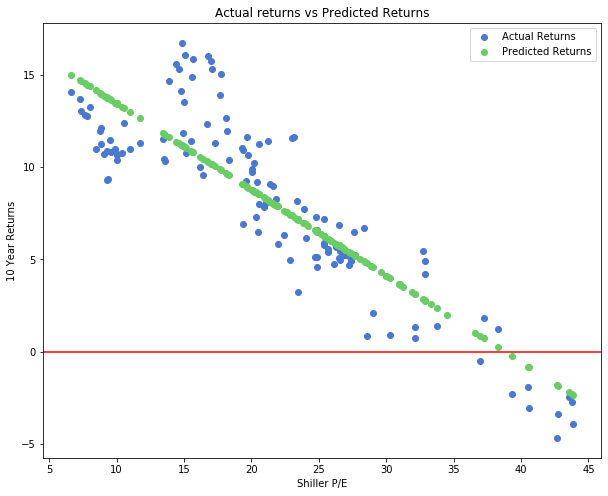

In [261]:
plt.figure(figsize = (10,8))
plt.scatter(data.column("Shiller P/E"), data.column("10 Year Returns"), label = "Actual Returns")
predicted = result.params[0] + result.params[1]*data.column("Shiller P/E")
plt.scatter(data.column("Shiller P/E"),predicted , label = "Predicted Returns")
plt.xlabel("Shiller P/E")
plt.ylabel("10 Year Returns")
plt.title("Actual returns vs Predicted Returns")
plt.legend()
plt.axhline(y=0, color='r', linestyle='-');

## Part 4: Multivariate Regression

As you calculated in Question 2.3, predicted return 10 years from now is roughly 2%. Historical average yearly returns in the long run have been 8%. Based on this, does it seem like a good time to invest?

Think about this. If on 2021-01-01, you decided to sell your investment in S&P 500 based on the 2% prediction, you would have missed out on 5.7% growth in the first quarter of this year (which is 25% annualized). 

So while on the long run P/E valuation is a good metric, on the short run, we need other data.

Investor Allocation to Stocks aka Equity Allocation is another common valuation metric. Intuitively, you can think of it as the % of the porfolio people allocation to stocks versus other assets.

Mathematically it is as follows. 

[Investor Allocation to Stocks (Average)](https://iranthenumbers.wordpress.com/2020/07/04/http-www-philosophicaleconomics-com-2013-12-the-single-greatest-predictor-of-future-stock-market-returns/) = Market Value of All Stocks / (Market Value of All Stocks + Total Liabilities of All Real Economic Borrowers)

[FRED](https://fred.stlouisfed.org/graph/?g=qis) updates the values quarterly for this metric.

First, lets look at some plots for this.

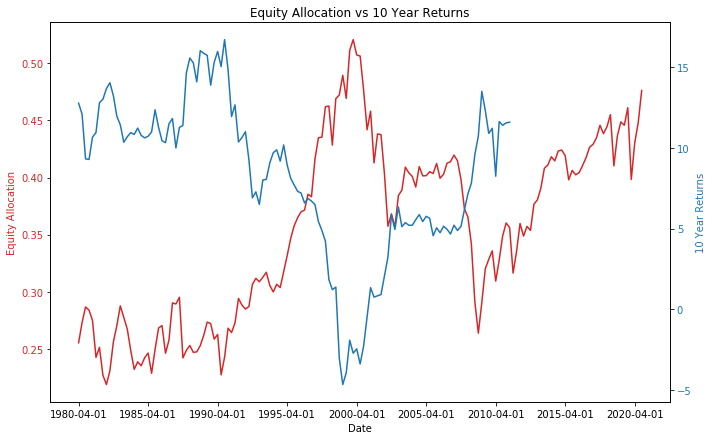

In [262]:
fig, ax1 = plt.subplots(1,1, figsize = (10,6))
tick_spacing = 20

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Equity Allocation', color=color)
ax1.plot(data.column("Date"), data.column("Equity Allocation"), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('10 Year Returns', color=color) 
ax2.plot(data.column("Date"), data.column("10 Year Returns"), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

fig.tight_layout() 

plt.title("Equity Allocation vs 10 Year Returns")
plt.show();

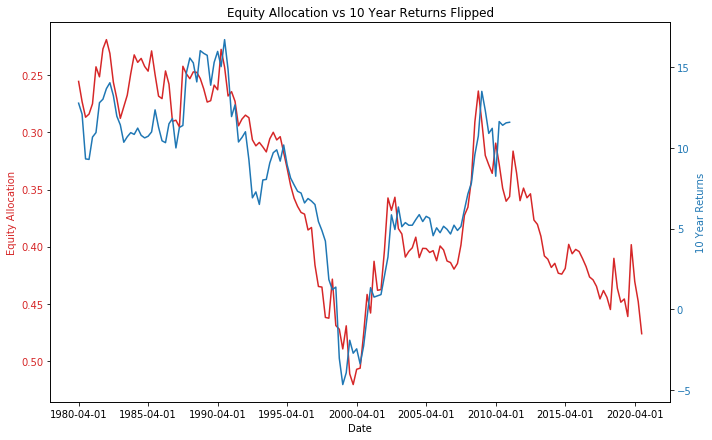

In [263]:
fig, ax1 = plt.subplots(1,1, figsize = (10,6))
tick_spacing = 20

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Equity Allocation', color=color)
ax1.plot(data.column("Date"), data.column("Equity Allocation"), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.invert_yaxis()

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('10 Year Returns', color=color)
ax2.plot(data.column("Date"), data.column("10 Year Returns"), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

fig.tight_layout() 

plt.title("Equity Allocation vs 10 Year Returns Flipped")
plt.show()

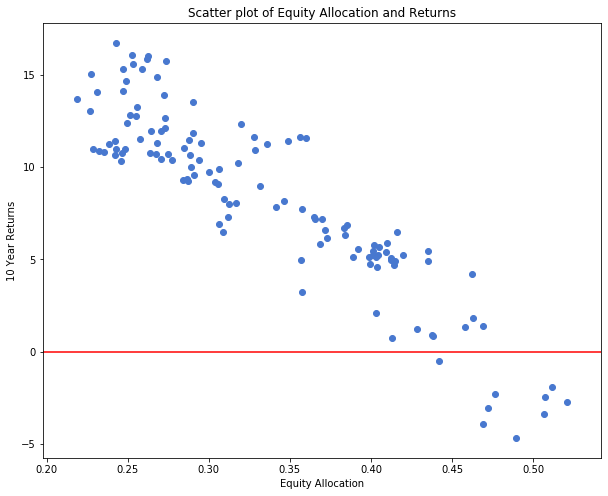

In [264]:
plt.figure(figsize = (10,8))
plt.scatter(data.column("Equity Allocation"), data.column("10 Year Returns"))
plt.xlabel("Equity Allocation")
plt.ylabel("10 Year Returns")
plt.title("Scatter plot of Equity Allocation and Returns")
plt.axhline(y=0, color='r', linestyle='-');

So, Equity Allocation is also a good tracking indicator.

**Question 3.1:** Similar to Q2.1, use Equity Allocation as an independent variable to predict 10 year returns. Save the regression model to the variable `result2`.


```
BEGIN QUESTION
name: q3_1
points: 2
manual: false
```

In [265]:
# BEGIN SOLUTION NO PROMPT
x = data.select("Equity Allocation").to_df()               # Separate features (independent variables) 
y = data.select("10 Year Returns").to_df()                 # Separate target (outcome variable)
model = sm.OLS(y, sm.add_constant(x), missing = 'drop')    # Initialize the OLS regression model
result2 = model.fit()                                      # Fit the regression model and save it to a variable
# END SOLUTION
""" # BEGIN PROMPT
x = data.select(...).to_df()
y = data.select(...).to_df()
model = sm.OLS(..., sm.add_constant(...), missing = 'drop')
result2 = model.fit()
"""; # END PROMPT
result2.summary()                                          # Display a summary of results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        10 Year Returns   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     595.4
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           5.76e-49
Time:                        00:27:11   Log-Likelihood:                -264.53
No. Observations:                 125   AIC:                             533.1
Df Residuals:                     123   BIC:                             538.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                27.0689      0.794     34.110      0.000      25.498      28.640
Equity Allocation   -56.0880      2.299    -24.400      0.000     -60.638     -51.538
==============================================================================
Omnibus:                        1.420   Durbin-Watson:                   0.597
Prob(Omnibus):                  0.492   Jarque-Bera (JB):                1.241
Skew:                           0.069   Prob(JB):                        0.538
Kurtosis:                       2.532   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [266]:
## TEST ##
len(result2.params) == 2

True

In [267]:
## TEST ##
sum(np.equal(result2.params.index.values, ['const', 'Equity Allocation'])) == 2

True

In [268]:
## HIDDEN TEST ##
np.isclose(result2.params[0], 27.068921233154036, atol = 0.05)

True

In [269]:
## HIDDEN TEST ##
np.isclose(result2.params[1], -56.08796911198026, atol = 0.05)

True

**Question 3.2:** Use the estimates for $\hat{\alpha}$ and $\hat{\beta}$ to predict the returns for 2020-10-01. Store it in a variable called `prediction_today2`.

```
BEGIN QUESTION
name: q3_2
points: 1
manual: false
```

In [270]:
# BEGIN SOLUTION NO PROMPT
prediction_today2 = result2.params[0] + result2.params[1]*0.47624
# END SOLUTION
""" # BEGIN PROMPT
prediction_today2  = ...
"""; # END PROMPT
prediction_today2

0.35758682326455826

In [271]:
## TEST ##
prediction_today2 <= 10

True

In [272]:
## HIDDEN TEST ##
np.isclose(prediction_today2, 0.35758682326455826 , atol = 0.05)

True

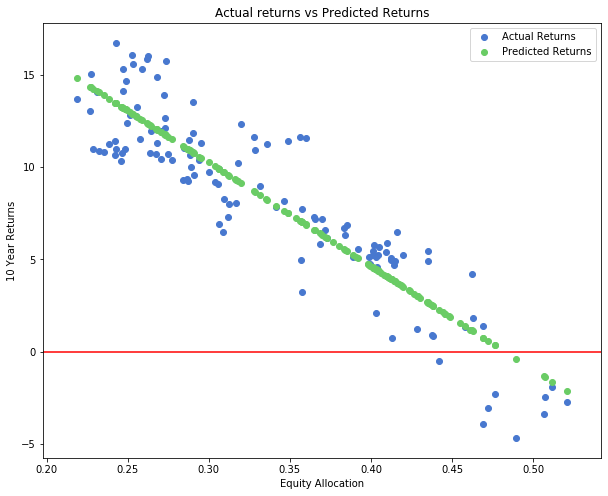

In [273]:
plt.figure(figsize = (10,8))
plt.scatter(data.column("Equity Allocation"), data.column("10 Year Returns"), label = "Actual Returns")
predicted = result2.params[0] + result2.params[1]*data.column("Equity Allocation")
plt.scatter(data.column("Equity Allocation"),predicted , label = "Predicted Returns")
plt.xlabel("Equity Allocation")
plt.ylabel("10 Year Returns")
plt.title("Actual returns vs Predicted Returns")
plt.legend()
plt.axhline(y=0, color='r', linestyle='-');

**Question 3.3:** Use both P/E and Equity Allocaition to predict returns. P/E should relate to the $\hat{\beta}$ coefficient i.e., select P/E column first in the code. Save the regression model to the variable `result3`.

```
BEGIN QUESTION
name: q3_3
points: 2
manual: false
```

In [274]:
# BEGIN SOLUTION NO PROMPT
x = data.select("Shiller P/E", "Equity Allocation").to_df()   # Separate features (independent variables) 
y = data.select("10 Year Returns").to_df()                    # Separate target (outcome variable)
model = sm.OLS(y, sm.add_constant(x), missing = 'drop')       # Initialize the OLS regression model
result3 = model.fit()                                         # Fit the regression model and save it to a variable
# END SOLUTION
""" # BEGIN PROMPT
x = data.select(..., ...).to_df()
y = data.select(...).to_df()
model = sm.OLS(..., sm.add_constant(...), missing = 'drop')
result3 = model.fit()
"""; # END PROMPT
result3.summary()                                             # Display a summary of results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        10 Year Returns   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     300.6
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           7.15e-48
Time:                        00:27:14   Log-Likelihood:                -263.60
No. Observations:                 125   AIC:                             533.2
Df Residuals:                     122   BIC:                             541.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                25.8202      1.217     21.216      0.000      23.411      28.229
Shiller P/E          -0.0806      0.060     -1.350      0.180      -0.199       0.038
Equity Allocation   -47.2896      6.908     -6.845      0.000     -60.965     -33.614
==============================================================================
Omnibus:                        2.668   Durbin-Watson:                   0.502
Prob(Omnibus):                  0.263   Jarque-Bera (JB):                2.194
Skew:                           0.197   Prob(JB):                        0.334
Kurtosis:                       2.484   Cond. No.                         896.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [275]:
## TEST ##
len(result3.params) == 3

True

In [276]:
## TEST ##
sum(np.equal(result3.params.index.values, ['const', 'Shiller P/E', 'Equity Allocation'])) == 3

True

In [277]:
## HIDDEN TEST ##
np.isclose(result3.params[0], 25.82020849674827, atol = 0.05)

True

In [278]:
## HIDDEN TEST ##
np.isclose(result3.params[1], -0.080595046371424, atol = 0.05)

True

In [279]:
## HIDDEN TEST ##
np.isclose(result3.params[2], -47.289573059240716, atol = 0.05)

True

**Question 3.4:** Use the estimates for $\hat{\alpha}$, $\hat{\beta_1}$ and $\hat{\beta_2}$to predict the returns for 2020-10-01. Store it in a variable called `prediction_today3`.


```
BEGIN QUESTION
name: q3_4
points: 1
manual: false
```

In [280]:
# BEGIN SOLUTION NO PROMPT
prediction_today3 = result3.params[0] + result3.params[1]*31.28 + result3.params[2]*0.47624
# END SOLUTION
""" # BEGIN PROMPT
prediction_today3  = ...
"""; # END PROMPT
prediction_today3

0.7780091725173257

In [281]:
## TEST ##
prediction_today3 <= 5

True

In [282]:
## HIDDEN TEST ##
np.isclose(prediction_today3, 0.7780091725173257 , atol = 0.05)

True

Since we have 2 'x' variables, we will need to make a 3D plot to see hour our predicted values line up with our actual values.

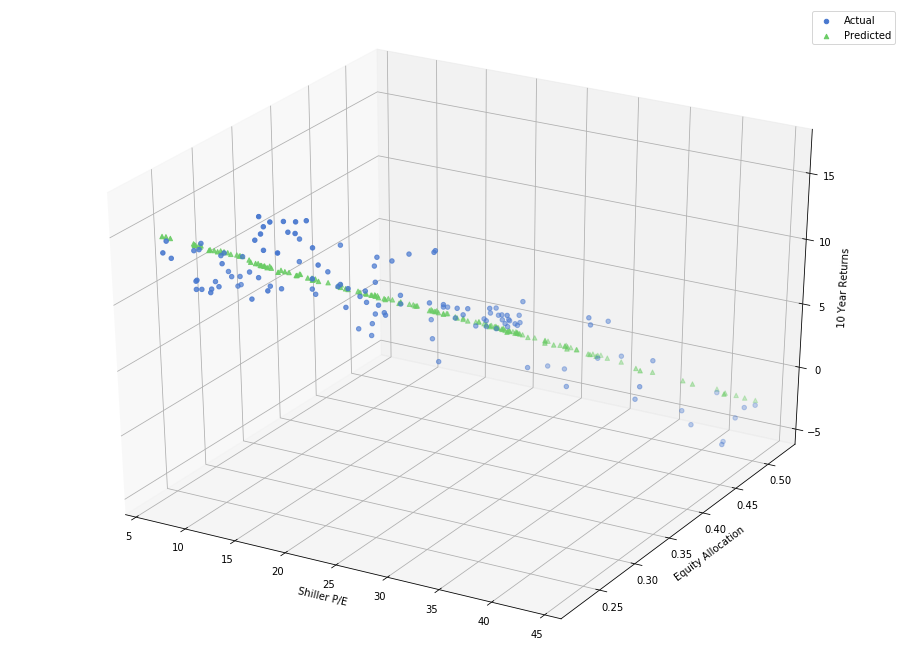

In [283]:
fig = plt.figure(figsize = (16,12))
ax = fig.add_subplot(projection='3d')


xs = data.column("Shiller P/E")
ys = data.column("Equity Allocation")
zs =  data.column("10 Year Returns")
ax.scatter(xs, ys, zs, marker='o')

predicted = result3.params[0] + result3.params[1]*data.column("Shiller P/E") + result3.params[2]*data.column("Equity Allocation")

xs = data.column("Shiller P/E")
ys = data.column("Equity Allocation")
zs =  predicted
ax.scatter(xs, ys, zs, marker='^')

ax.set_xlabel('Shiller P/E')
ax.set_ylabel('Equity Allocation')
ax.set_zlabel('10 Year Returns')

plt.legend(["Actual", "Predicted"])
plt.show()

## Part 5: Comparing Regressions

Let's compare the regression model with just Equity Allocation versus the model with both P/E and Equity Allocation. The predictions for 2020-10-01 are simlar enough for both. So are these models differnt performance wise?

We will use a metric called Adjusted R-squared to comare. Statsmodels regression results also calulated these for us. You can find Adj. R-squared in the second row from the top on the right. 

We will not formally teach Adjusted R-squared in this class. So an intuitve explaination would suffice. 

The [adjusted R-squared](https://blog.minitab.com/en/adventures-in-statistics-2/multiple-regession-analysis-use-adjusted-r-squared-and-predicted-r-squared-to-include-the-correct-number-of-variables#:~:text=The%20adjusted%20R%2Dsquared%20is,less%20than%20expected%20by%20chance.) is a modified version of R-squared that has been adjusted for the number of predictors (features) in the model. The adjusted R-squared increases only if the new term improves the model more than would be expected by chance. It decreases when a predictor improves the model by less than expected by chance. 

The Adj R-squared for model 2 is 0.827. The Adj R-squared for model 3 is 0.829. So adding P/E as another variable did not add much to the model in terms of accuracy or prediction power. Instead, it added more complexity and took more compute power. We had very less data, but you can imagine it would be a problem with a lot more data.

A good question to ask is why did the model not improve? Lets look the data more closely.

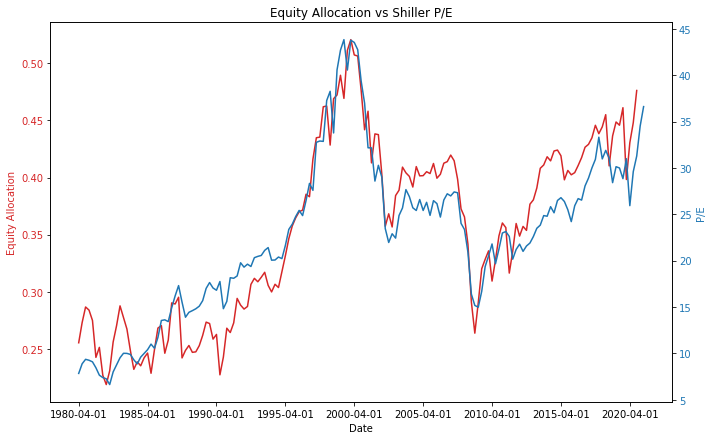

In [284]:
fig, ax1 = plt.subplots(1,1, figsize = (10,6))
tick_spacing = 20

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Equity Allocation', color=color)
ax1.plot(data.column("Date"), data.column("Equity Allocation"), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('P/E', color=color)  
ax2.plot(data.column("Date"), data.column("Shiller P/E"), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

fig.tight_layout()  

plt.title("Equity Allocation vs Shiller P/E")
plt.show();

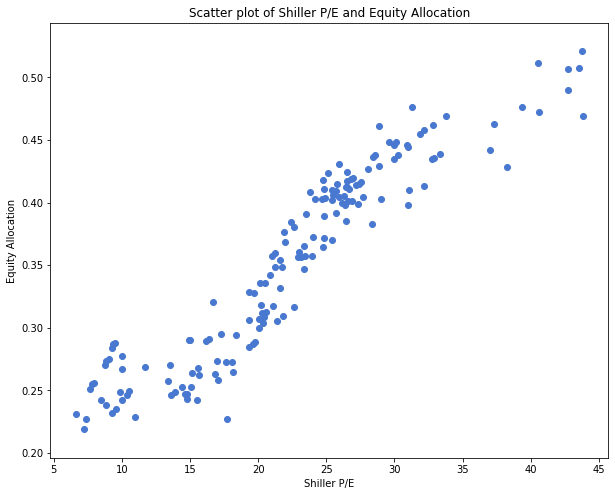

In [285]:
plt.figure(figsize = (10,8))
plt.scatter(data.column("Shiller P/E"), data.column("Equity Allocation"))
plt.xlabel("Shiller P/E")
plt.ylabel("Equity Allocation")
plt.title("Scatter plot of Shiller P/E and Equity Allocation");

Both Equity Allocation and Shiller P/E track each other pretty closely, as one would expect.

lets calculate the correlation between the two variables.

In [286]:
# No need to understand the code
corr = np.corrcoef(data.column("Shiller P/E")[:-2], data.column("Equity Allocation")[:-2])[0][1]
corr

0.9340638200928

In fact, the correlation between P/E and Equity Allocation is quite high; 0.93. This shows that given one of the features, we practically know the other feature. Hence, having both in a model is generally not useful. This problem is called **Multicollinearity**.

Congrats on finishing this lab. Now you can do analysis similar to WSJ!!!